<a href="https://colab.research.google.com/github/FieldTien/im2col-to-Group-Convolution/blob/main/im2col_to_group_Conv2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# im2col to Group Convolution 
## Introduction
im2col is the method of implement Convolution layers to matrix inner product form,  it spent more memory but the matrix prduct form is easier to parallelize in GPU.

Here, we will quickly review the nomal Convolution(group=1) by using im2col.
And extend the im2col to group convolution.

At last part , we do the run time experiment on CPU and GPU enviroment,and discuss why the run time will take longer if the group becomes larger here. 

The reference is following from the [article ](https://zhuanlan.zhihu.com/p/63974249)
>

## Nomal Convolution(group=1) by using im2col
## One input channels and one kernel(3x3)

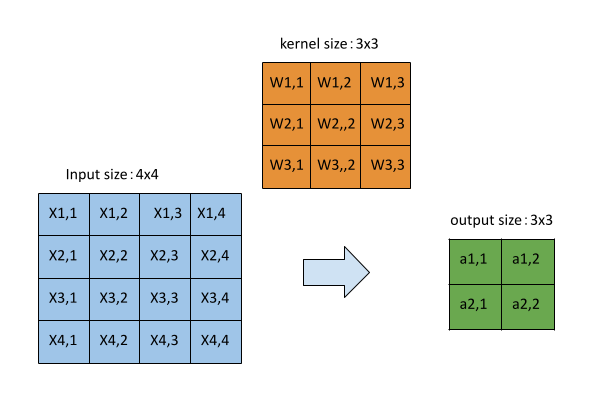


Suppose $x$ is input tensor with size 4x4, $w$ is a conv kernel with size 3x3, and $A$ is the conv output which sizes is 2x2.

$$x = 
 \left[
 \begin{matrix}
   x_{1,1} & x_{1,2} & x_{1,3}& x_{1,4} \\
   x_{2,1} & x_{2,2} & x_{2,3}& x_{2,4} \\
   x_{3,1} & x_{3,2} & x_{3,3}& x_{3,4} \\
   x_{4,1} & x_{4,2} & x_{4,3}& x_{4,4} 
  \end{matrix}
  \right] \tag{1}
$$


$$w = 
 \left[
 \begin{matrix}
   w_{1,1} & w_{1,2} & w_{1,3} \\
   w_{2,1} & w_{2,2} & w_{2,3} \\
   w_{3,1} & w_{3,2} & w_{3,3}
  \end{matrix}
  \right] \tag{2}
$$

Convolution of ouput A is

$$A = 
 \left[
 \begin{matrix}
   x_{1,1/3,3}\times w &  x_{1,2/3,4}\times w  \\
   x_{2,1/4,3}\times w &  x_{2,2/4,4}\times w
  \end{matrix}
  \right]= 
  \begin{bmatrix}
     a_{1,1} & a_{1,2}\\
     a_{2,1} & a_{2,2} \\
  \end{bmatrix}
$$

which 
$$x_{i,j/ i+2,j+2} = 
 \left[
 \begin{matrix}
   x_{i,j} & x_{i+1,j} & x_{i+2,j} \\
   x_{i,j+1} & x_{i+1,j+1} & x_{i+2,j+1} \\
   x_{i,j+2} & x_{i+1,j+2} & x_{i+2,j+2} \\
  \end{matrix}
  \right] 
$$
Now we let $$x^{([i-1]*3+j)}=x_{i,j/i+2,j+2}  \quad means  \quad  x^{(1)}=x_{1,1/3,3}   \quad and  \quad   x^{(2)}=x_{1,2/3,4}
$$

And flatten $x^{(i)}$ and w to the column or row

$$x^{([i-1]*3+j)} = 
 \begin{bmatrix}
   x_{i,j} & x_{i+1,j} & x_{i+2,j} & x_{i,j+1} & x_{i+1,j+1} &     x_{i+2,j+1}&x_{i,j+2} & x_{i+1,j+2} & x_{i+2,j+2} \\
  \end{bmatrix}
$$
$$W = 
 \begin{bmatrix}
   w_{1,1} & w_{1,2} & w_{1,3} & w_{2,1} & w_{2,2} & w_{2,3} & w_{3,1} & w_{3,2} & w_{3,3} \\
  \end{bmatrix}^{T}
$$

Concat for each $x^{(i)}$ to  $X$, the size of $X$ is 4x9 

$$X = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     x^{(3)} \\
     x^{(4)} \\
  \end{bmatrix}
$$  

Then we get the matrix product form  of ouput A

$$A = XW = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     x^{(3)} \\
     x^{(4)} \\
  \end{bmatrix}W=\begin{bmatrix}
     a_{1} \\
     a_{2} \\
     a_{3} \\
     a_{4} \\
  \end{bmatrix} \underrightarrow{resize}
  \begin{bmatrix}
     a_{1} & a_{2}\\
     a_{3} & a_{4} \\
  \end{bmatrix} =
  \begin{bmatrix}
     a_{1,1} & a_{1,2}\\
     a_{2,1} & a_{2,2} \\
  \end{bmatrix}
$$  


## Two input channels and one kernel(3x3)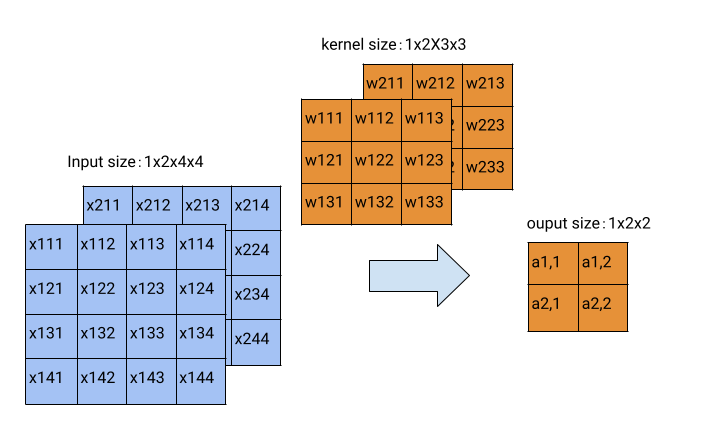

Suppose $x$ is input tensor with size 1x2x4x4,and kernel  size of $w$  is 1x2x3x3, then $A$ is output with size 1x1x2x2

$$x = 
 \begin{pmatrix}
 \begin{bmatrix}
   x_{1,1,1} & x_{1,1,2} & x_{1,1,3}& x_{1,1,4} \\
   x_{1,2,1} & x_{1,2,2} & x_{1,2,3}& x_{1,2,4} \\
   x_{1,3,1} & x_{1,3,2} & x_{1,3,3}& x_{1,3,4} \\
   x_{1,4,1} & x_{1,4,2} & x_{1,4,3}& x_{1,4,4} 
 \end{bmatrix}
 \begin{bmatrix}
   x_{2,1,1} & x_{2,1,2} & x_{2,1,3}& x_{2,1,4} \\
   x_{2,2,1} & x_{2,2,2} & x_{2,2,3}& x_{2,2,4} \\
   x_{2,3,1} & x_{2,3,2} & x_{2,3,3}& x_{2,3,4} \\
   x_{2,4,1} & x_{2,4,2} & x_{2,4,3}& x_{2,4,4} 
 \end{bmatrix}
 \end{pmatrix}
$$


$$w = 
 \begin{pmatrix}
 \begin{bmatrix}
   w_{1,1,1} & w_{1,1,2} & w_{1,1,3} \\
   w_{1,2,1} & w_{1,2,2} & w_{1,2,3} \\
   w_{1,3,1} & w_{1,3,2} & w_{1,3,3}
   \end{bmatrix}
  \begin{bmatrix}
   w_{2,1,1} & w_{2,1,2} & w_{2,1,3} \\
   w_{2,2,1} & w_{2,2,2} & w_{2,2,3} \\
   w_{2,3,1} & w_{2,3,2} & w_{2,3,3}
   \end{bmatrix}
 \end{pmatrix}  
$$

Combine the $x^{(1,i)}$ and $x^{(2,i)}$ like $x^{(1)}$ combines the $x^{(1,1)}$ and $x^{(2,1)}$, and flatten it 
$$x^{(1)} = 
\begin{bmatrix}
   x_{1,1,1} & x_{1,1,2} & x_{1,1,3} \\
   x_{1,2,1} & x_{1,2,2} & x_{1,2,3} \\
   x_{1,3,1} & x_{1,3,2} & x_{1,3,3} \\
   x_{2,1,1} & x_{2,1,2} & x_{2,1,3} \\
   x_{2,2,1} & x_{2,2,2} & x_{2,2,3} \\
   x_{2,3,1} & x_{2,3,2} & x_{2,3,3} \\
   \end{bmatrix}= 
\begin{bmatrix}
   x_{1} & x_{2} & x_{3} \\
   x_{4} & x_{5} & x_{6} \\
   x_{7} & x_{8} & x_{9} \\
   x_{10} & x_{11} & x_{12} \\
   x_{13} & x_{14} & x_{15} \\
   x_{16} & x_{17} & x_{18} \\
   \end{bmatrix}
$$
$$x^{(1)} = 
 \begin{bmatrix}
   x_{1} & x_{2} & x_{3} & x_{4} & x_{5} & x_{6}&x_{7} & x_{8} & x_{9}  &
   x_{10} & x_{11} & x_{12} & x_{13} & x_{14} &     x_{15}&x_{16} & x_{17} & x_{18}\\
  \end{bmatrix} 
$$  
Which implies

$$x^{([i-1]*3+j)} = 
 \begin{bmatrix}
   x_{1,i,j} & x_{1,i+1,j} & x_{1,i+2,j} & x_{1,i,j+1} & x_{1,i+1,j+1} &     x_{1,i+2,j+1}&x_{1,i,j+2} & x_{1,i+1,j+2} & x_{1,i+2,j+2}  &
   x_{2,i,j} & x_{2,i+1,j} & x_{2,i+2,j} & x_{2,i,j+1} & x_{2,i+1,j+1} &     x_{2,i+2,j+1}&x_{2,i,j+2} & x_{2,i+1,j+2} & x_{2,i+2,j+2}\\
  \end{bmatrix} 
$$  

And also combine $w_1$ and $w_2$ and flatten it  to one colunm

$$W = 
 \begin{bmatrix}
   w_1 \\ w_2
 \end{bmatrix}=
 \begin{bmatrix}
   w_{1,1,1} & w_{1,1,2} & w_{1,1,3} \\
   w_{1,2,1} & w_{1,2,2} & w_{1,2,3} \\
   w_{1,3,1} & w_{1,3,2} & w_{1,3,3} \\
   w_{2,1,1} & w_{2,1,2} & w_{2,1,3} \\
   w_{2,2,1} & w_{2,2,2} & w_{2,2,3} \\
   w_{2,3,1} & w_{2,3,2} & w_{2,3,3} \\
 \end{bmatrix}=
 \begin{bmatrix}
   w_{1} & w_{2} & w_{3} \\
   w_{4} & w_{5} & w_{6} \\
   w_{7} & w_{8} & w_{9} \\
   w_{10} & w_{11} & w_{12} \\
   w_{13} & w_{15} & w_{15} \\
   w_{16} & w_{17} & w_{18} \\
 \end{bmatrix}
$$

The size of $w$ is 18x1

$$w = \begin{bmatrix}
   w_{1} & w_{2} & w_{3}  &
   w_{4} & w_{5} & w_{6}  &
   w_{7} & w_{8} & w_{9}  &
   w_{10} & w_{11} & w_{12} &
   w_{13} & w_{15} & w_{15} &
   w_{16} & w_{17} & w_{18} \\
 \end{bmatrix}^{T}
$$

Concat for each $x^{(i)}$ to  $X$, the size of $X$ is 4x18
$$X = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     x^{(3)} \\
     x^{(4)} \\
  \end{bmatrix}
$$  

which leads ouput A to
$$A = XW = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     x^{(3)} \\
     x^{(4)} \\
  \end{bmatrix}W=\begin{bmatrix}
     a_{1} \\
     a_{2} \\
     a_{3} \\
     a_{4} \\
  \end{bmatrix}\underrightarrow{resize}
  \begin{bmatrix}
     a_{1} & a_{2}\\
     a_{3} & a_{4} \\
  \end{bmatrix} =
  \begin{bmatrix}
     a_{1,1} & a_{1,2}\\
     a_{2,1} & a_{2,2} \\
  \end{bmatrix}
$$  

## Two input channels and two kernel(3x3)
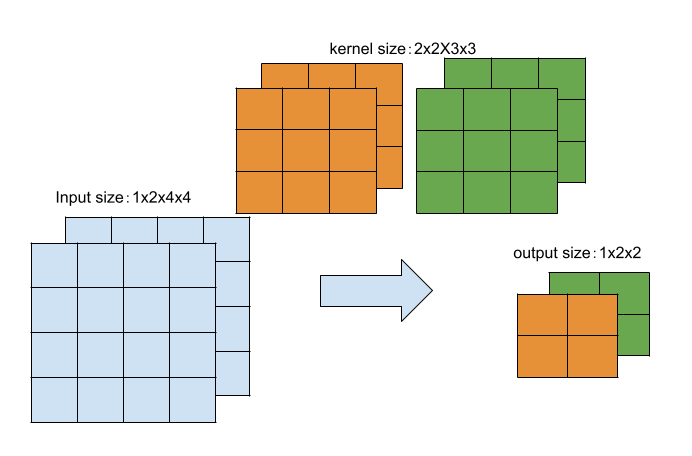

Suppose $x$ is the input tensor with size 1x2x4x4,$w$ is a kernel with size 2x2x3x3 , then the size of  output $A$ is  1x2x2x2

The size of X is still 4x18 

$$X = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     x^{(3)} \\
     x^{(4)} \\
  \end{bmatrix}
$$  

But size of W becomes to 18x2
$$W = 
  \begin{bmatrix}
   W_1 & W_2
  \end{bmatrix}
$$  

which leads ouput A to
$$A = ZW = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     x^{(3)} \\
     x^{(4)} \\
  \end{bmatrix}
  \begin{bmatrix}
   W_1 & W_2
  \end{bmatrix} =
  \begin{bmatrix}
     a_{1} & a_{5}\\
     a_{2} & a_{6}\\
     a_{3} & a_{7}\\
     a_{4} & a_{8}\\
  \end{bmatrix} \underrightarrow{resize}
$$
$$
  \begin{bmatrix}
     \left(\begin{array}{cc} 
     a_{1} & a_{2}\\
     a_{3} & a_{4}\\
     \end{array}\right)
  \end{bmatrix}    
     \\
   \begin{bmatrix}   
     \left(\begin{array}{cc} 
     a_{5} & a_{6}\\
     a_{7} & a_{8}\\
     \end{array}\right)
  \end{bmatrix} 
$$  

## Two samples,Two channels and two kernels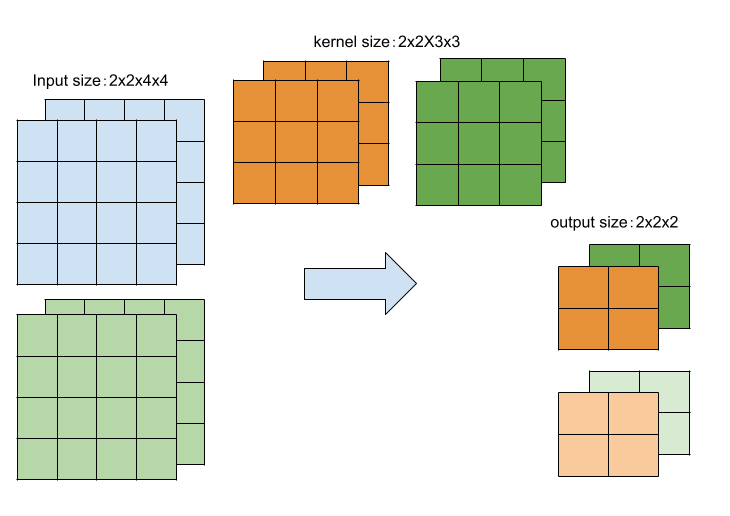

Suppose $x$ is input tensor with size 2x2x4x4, W is a kernel with size 2x2x3x3, then the size of  output $A$ is  2x2x2x2

$$X_1 = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     x^{(3)} \\
     x^{(4)} \\
  \end{bmatrix}
  \quad and  \quad  
  X_2 = 
  \begin{bmatrix}
     x^{(5)} \\
     x^{(6)} \\
     x^{(7)} \\
     x^{(8)} \\
  \end{bmatrix}
$$  
$$A = XW = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     x^{(3)} \\
     x^{(4)} \\
     x^{(5)} \\
     x^{(6)} \\
     x^{(7)} \\
     x^{(8)} \\
  \end{bmatrix}
  \begin{bmatrix}
   W_1 & W_2
  \end{bmatrix} =
  \begin{bmatrix}
     a_{1} & a_{5}\\
     a_{2} & a_{6}\\
     a_{3} & a_{7}\\
     a_{4} & a_{8}\\
     a_{9} & a_{13}\\
     a_{10} & a_{14}\\
     a_{11} & a_{15}\\
     a_{12} & a_{16}\\
  \end{bmatrix}  \underrightarrow{resize}
$$  
$$
  \begin{pmatrix} 
  \begin{bmatrix}
     \left(\begin{array}{cc} 
     a_{1} & a_{2}\\
     a_{3} & a_{4}\\
     \end{array}\right)
     \\
     \left(\begin{array}{cc} 
     a_{5} & a_{6}\\
     a_{7} & a_{8}\\
     \end{array}\right)
  \end{bmatrix} \end{pmatrix}  \\ 
  \begin{pmatrix}  
  \begin{bmatrix}
     \left(\begin{array}{cc} 
     a_{9} & a_{10}\\
     a_{11} & a_{12}\\
     \end{array}\right)
     \\
     \left(\begin{array}{cc} 
     a_{13} & a_{14}\\
     a_{15} & a_{16}\\
     \end{array}\right)
  \end{bmatrix} \\ 
  \end{pmatrix}
$$  

## General formula 

$$A = XW = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     . \\
     . \\
     . \\
     x^{(m)} \\
  \end{bmatrix}
  \begin{bmatrix}
   w_1 & w_2&  . & . & .& w_n
  \end{bmatrix} 
$$  


## pytorch example 

In [ ]:
import torch 
def im2col(img,kernal_size,stride=1):
  col = nn.Unfold(kernel_size=kernal_size,dilation=1,padding=0,stride=stride)(img)
  col = torch.permute(col,(0,2,1))
  col = torch.flatten(col, 0, 1)
  return col

im2col function makes input $x$ to output $X$
whichs 
$$X= 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     . \\
     . \\
     . \\
     x^{(m)} \\
  \end{bmatrix}
$$ 


In [ ]:
def Conv_2d(x,w,stride=1,padding='same'):
  FN, C, ksize, ksize = w.shape
  if padding == 'same':
    p = ksize // 2
    x = nn.ZeroPad2d(1)(x)
  N, C, H, W = x.shape  
  col = im2col(x, ksize, stride)
  w = torch.transpose(w.reshape(w.shape[0], -1),0,1)
  z = torch.matmul(col, w)
  out_w = (W - ksize) // stride + 1
  out_h = (H - ksize) // stride + 1
  z = z.reshape((N,out_h,out_w,FN))
  z = torch.permute(z,(0,3,1,2))
  return z

Conv_2d function makes A as inner product form
$$A = XW = 
  \begin{bmatrix}
     x^{(1)} \\
     x^{(2)} \\
     . \\
     . \\
     . \\
     x^{(m)} \\
  \end{bmatrix}
  \begin{bmatrix}
   W_1 & W_2&  . & . & .& W_n
  \end{bmatrix} 
$$ 


# Comparing with nn.Conv2d example1
we can see the differece distance $\sum(nn.Conv2d-Conv2d(ours))^2 < 0.00001$ 

In [ ]:
import torch.nn as nn
a = torch.arange(75).reshape([1,3,5,5]).type(torch.float32)
conv = nn.Conv2d(3,6,kernel_size=3,stride=1,padding=1, bias=False)
nn_out, self_out = conv(a),Conv_2d(a,conv.weight,stride=1,padding='same')
distance = float(torch.sum(torch.square(nn_out-self_out)).detach().numpy())
print("The sum of square distance is :",distance)

The sum of square distance is : 3.0831870390102267e-10


# Comparing with nn.Conv2d example2

In [ ]:
a = torch.randn([4,3,5,5])
conv = nn.Conv2d(3,1,kernel_size=3,stride=1,padding=1, bias=False)
nn_out, self_out = conv(a),Conv_2d(a,conv.weight,stride=1,padding='same')
distance = float(torch.sum(torch.square(nn_out-self_out)).detach().numpy())
print("The sum of square distance is :",distance)

The sum of square distance is : 2.1593545094372724e-13


# Comparing with nn.Conv2d example3

In [ ]:
conv = nn.Conv2d(3,7,kernel_size=3,stride=1,padding=1, bias=False)
nn_out, self_out = conv(a),Conv_2d(a,conv.weight,stride=1,padding='same')
distance = float(torch.sum(torch.square(nn_out-self_out)).detach().numpy())
print("The sum of square distance is :",distance)

The sum of square distance is : 1.6421737017088822e-12


## Make General into Group Convution 
Suppose the batch_size=$b$, input_channel=$c$, ouput_channel=$m$ , Group=$g$, kernel_size=$k_h\times k_w$, and the output $A$ size is $(b,m,o_h,o_w)$,we know the weights $w$ size is $(c,(m/g),k_h,k_w)$.
First split $x^{(i)}$ into g groups 

$$x^{(i)} = 
  \begin{bmatrix}
   x_1^{(i)} & x_2^{(i)}& x_3^{(i)} & . & .& .& .& x_{c \times k_h \times k_w}^{(i)}
  \end{bmatrix}\to 
  \begin{bmatrix}
   x_{[1]}^{(i)} . &  . & .&    x_{[g]}^{(i)}
  \end{bmatrix}
$$ 
And make $w$ to $W$(sizes is $[(m/g)\times k_h \times k_w,c]$) like the step which we mentioned above, and  split $W_{i}$ into $g$ groups 

$$W_ = 
  \begin{bmatrix}
   W_1 & W_2 & W_3 & . & .& .& .& W_{m}
  \end{bmatrix}\to 
  \begin{bmatrix}
   W_{[1]} . &  . & .&   W_{[g]}
  \end{bmatrix}
$$ 

Then we make inner product for each group

***$A$ is empty tensor***

***for index in groups:***

$$ A_{index} = 
\begin{bmatrix}
   x_{[index]}^{(1)} \\ x_{[index]}^{(2)} \\  . \\ .\\ .\\  x_{[index]}^{(b\times o_{h}\times o_{w})}
  \end{bmatrix} 
  \begin{bmatrix}
    W_{[index]}
  \end{bmatrix} 
$$ 
***$A$ = concatenate($A$,$A_{index}$)***

***At last, we resize $A$ into $(b,m,o_h,o_w)$***
  

##First define the split function

If input $a=[1,2,3,4,5,6]$ and $n$=2, ouput will be $[[1,2,3] , [4,5,6]]$



In [ ]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))


## Group Convution function 

In [ ]:
def Conv_2d(x,w,stride=1,padding='same',device='cpu'):
  FN, w_C, ksize, ksize = w.shape
  if padding == 'same':
    p = ksize // 2
    x = nn.ZeroPad2d(1)(x)
  N, x_C, H, W = x.shape   
  out_w = (W - ksize) // stride + 1
  out_h = (H - ksize) // stride + 1 
  col = im2col(x, ksize, stride)
  group = x_C//w_C
  kernel_flatten_group = list(split(list(range(x_C*ksize*ksize)), group))
  channel_split = list(split(list(range(FN)), group))
  out_channel = torch.tensor([]).to(device)
  for index,i in enumerate(kernel_flatten_group):
    sub_col = col[:,i] 
    sub_w = w[channel_split[index]]
    sub_w = torch.transpose(sub_w.reshape(sub_w.shape[0], -1),0,1)
    z = torch.matmul(sub_col, sub_w)   
    out_channel = torch.cat((out_channel,z),axis=1) 
  out_channel = out_channel.reshape((N,out_h,out_w,FN)) 
  out_channel = torch.permute(out_channel,(0,3,1,2)) 
  return out_channel 
 

# Comparing with nn.Conv2d in Depthwise example

In [ ]:
import torch.nn as nn
inp = torch.randn([2,3,5,5])
conv = nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1,groups=3, bias=False)
nn_out, self_out = conv(a),Conv_2d(a,conv.weight,stride=1,padding='same')
distance = float(torch.sum(torch.square(nn_out-self_out)).detach().numpy())
print("The sum of square distance is :",distance)

The sum of square distance is : 3.62475782895999e-13


# Comparing with nn.Conv2d in Group=1 example


In [ ]:
import torch.nn as nn
inp = torch.randn([2,3,5,5])
conv = nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1,groups=1, bias=False)
nn_out, self_out = conv(a),Conv_2d(a,conv.weight,stride=1,padding='same')
distance = float(torch.sum(torch.square(nn_out-self_out)).detach().numpy())
print("The sum of square distance is :",distance)

The sum of square distance is : 6.000825921240183e-13


# Comparing with nn.Conv2d in 1<Group<N example



In [ ]:
import torch.nn as nn
inp = torch.randn([2,4,5,5])
conv = nn.Conv2d(4,6,kernel_size=3,stride=1,padding=1,groups=2, bias=False)
nn_out, self_out = conv(inp),Conv_2d(inp,conv.weight,stride=1,padding='same')
distance = float(torch.sum(torch.square(nn_out-self_out)).detach().numpy())
print("The sum of square distance is :",distance)

The sum of square distance is : 1.5390466678866233e-14


## Define the Convolution class
Let bias and padding is false and same 

In [ ]:
def conv(x,w,stride=1,padding='same',device='cpu'):
  FN, w_C, ksize, ksize = w.shape
  if padding == 'same':
    p = ksize // 2
    x = nn.ZeroPad2d(1)(x)
  N, x_C, H, W = x.shape   
  out_w = (W - ksize) // stride + 1
  out_h = (H - ksize) // stride + 1 
  col = im2col(x, ksize, stride)
  group = x_C//w_C
  kernel_flatten_group = list(split(list(range(x_C*ksize*ksize)), group))
  channel_split = list(split(list(range(FN)), group))
  out_channel = torch.tensor([]).to(device)
  for index,i in enumerate(kernel_flatten_group):
    sub_col = col[:,i] 
    sub_w = w[channel_split[index]]
    sub_w = torch.transpose(sub_w.reshape(sub_w.shape[0], -1),0,1)
    z = torch.matmul(sub_col, sub_w)   
    out_channel = torch.cat((out_channel,z),axis=1) 
  out_channel = out_channel.reshape((N,out_h,out_w,FN)) 
  out_channel = torch.permute(out_channel,(0,3,1,2)) 
  return out_channel 
class Conv2d(nn.Module):
  def __init__(self,input_dim,output_dim,kernel_size,groups=1,stride=1,bias=False,device='cpu'):
    super(Conv2d, self).__init__()
    self.device = device
    self.weight = nn.Parameter(torch.randn(output_dim, input_dim//groups, kernel_size ,kernel_size))
  def forward(self,x):
    out = conv(x,self.weight,device=self.device)
    return out

## Test the CPU run time

In [ ]:
import time
import math


def count(a, m):
    t0 = time.time()
    for i in range(1000):
        b = m(a)
    return time.time() - t0

def th_test(in_channel=1024, size=19, batch=1):
    import torch as th
    import torch.nn as nn
    x = th.rand((batch, in_channel, size, size))
    x = x.to('cpu')
    out_channels_lsit = [256, 512, 1024, 2048]
    for out_channels in out_channels_lsit:
        n = int(math.log(min(in_channel, out_channels), 2))+1
        for i in range(n):
            g = int(math.pow(2, i))
            m = Conv2d(input_dim=in_channel,output_dim=out_channels,kernel_size=3,groups=g).to('cpu')
            t = count(x, m)
            print('OutChannel:{}, Group:{}, Time:{}'.format(out_channels, g, t))
if __name__=='__main__':
    print('Pytorch testing:')
    th_test(1024, 19, 1)  

Pytorch testing:
OutChannel:256, Group:1, Time:105.5525369644165
OutChannel:256, Group:2, Time:87.415855884552
OutChannel:256, Group:4, Time:75.83100509643555
OutChannel:256, Group:8, Time:61.14407730102539
OutChannel:256, Group:16, Time:54.64587688446045
OutChannel:256, Group:32, Time:55.89593577384949
OutChannel:256, Group:64, Time:59.459802865982056
OutChannel:256, Group:128, Time:60.382723569869995
OutChannel:256, Group:256, Time:76.0586621761322
OutChannel:512, Group:1, Time:140.5087366104126
OutChannel:512, Group:2, Time:103.32299280166626
OutChannel:512, Group:4, Time:83.89087414741516
OutChannel:512, Group:8, Time:66.36096215248108
OutChannel:512, Group:16, Time:58.61093854904175
OutChannel:512, Group:32, Time:57.62527370452881
OutChannel:512, Group:64, Time:63.72417116165161
OutChannel:512, Group:128, Time:67.02132201194763
OutChannel:512, Group:256, Time:90.6312005519867
OutChannel:512, Group:512, Time:130.06236124038696
OutChannel:1024, Group:1, Time:196.7652144432068
OutCha

## Test the GPU run time

In [ ]:
import time
import math


def count(a, m):
    t0 = time.time()
    for i in range(1000):
        b = m(a)
    return time.time() - t0

def th_test(in_channel=1024, size=19, batch=1):
    import torch as th
    import torch.nn as nn
    x = th.rand((batch, in_channel, size, size))
    x = x.to('cuda')
    out_channels_lsit = [256, 512, 1024, 2048]
    for out_channels in out_channels_lsit:
        n = int(math.log(min(in_channel, out_channels), 2))+1
        for i in range(n):
            g = int(math.pow(2, i))
            m = Conv2d(input_dim=in_channel,output_dim=out_channels,kernel_size=3,groups=g,device='cuda').to('cuda')
            t = count(x, m)
            print('OutChannel:{}, Group:{}, Time:{}'.format(out_channels, g, t))
if __name__=='__main__':
    print('Pytorch testing:')
    th_test(1024, 19, 1)  

Pytorch testing:
OutChannel:256, Group:1, Time:1.7174291610717773
OutChannel:256, Group:2, Time:1.8573293685913086
OutChannel:256, Group:4, Time:2.2768795490264893
OutChannel:256, Group:8, Time:3.0873501300811768
OutChannel:256, Group:16, Time:4.808594226837158
OutChannel:256, Group:32, Time:8.342319011688232
OutChannel:256, Group:64, Time:15.286559343338013
OutChannel:256, Group:128, Time:28.886051654815674
OutChannel:256, Group:256, Time:60.327316761016846
OutChannel:512, Group:1, Time:1.652827501296997
OutChannel:512, Group:2, Time:1.897989273071289
OutChannel:512, Group:4, Time:2.2482616901397705
OutChannel:512, Group:8, Time:3.109278440475464
OutChannel:512, Group:16, Time:4.82826566696167
OutChannel:512, Group:32, Time:8.43238639831543
OutChannel:512, Group:64, Time:15.250593662261963
OutChannel:512, Group:128, Time:29.340689420700073
OutChannel:512, Group:256, Time:57.45697236061096
OutChannel:512, Group:512, Time:120.49353790283203
OutChannel:1024, Group:1, Time:1.9039602279663

##Discussion


***$A$ is empty tensor***

***for index in groups:***

$$ A_{index} = 
\begin{bmatrix}
   x_{[index]}^{(1)} \\ x_{[index]}^{(2)} \\  . \\ .\\ .\\  x_{[index]}^{(b\times o_{h}\times o_{w})}
  \end{bmatrix} 
  \begin{bmatrix}
    W_{[index]}
  \end{bmatrix} 
$$ 
***$A$ = concatenate($A$,$A_{index}$)***

***At last, we resize $A$ into $(b,m,o_h,o_w)$***

When the group become larger, the process will repeat more times in for loop, even if $A_{index}$ become smaller, the process will take longer in GPU if we do not do the parrelize to for loop.